## Data loading for default of credit card clients dataset 

To use the data, simply load the pickle file

In [1]:
import pickle
import numpy as np
import pdb
import matplotlib.pyplot as plt
with open("train_test_split.pkl", "br") as fh:
    data = pickle.load(fh)
train_data = data[0]
test_data = data[1]

train_x = train_data[:,:23]
train_y = train_data[:,23] # labels are either 0 or 1
test_x = test_data[:,:23]
test_y = test_data[:,23] # labels are either 0 or 1

# converting the labels to +-1 

In [2]:
train_y = 2*train_y - 1
test_y = 2*test_y -1

# Designed weak classifier (Decision-Stump)

In [3]:
import pandas as pd
df = pd.DataFrame()
class Node:
    def __init__(self,split,loss=None): # split chosen from x values
        self.root_value = split
        self.left = None
        self.right = None
        self.loss = loss
        self.s = None
        self.b = None
        self.missclassification_error = None
    def predict_class(self):
        # In prediction we just count whats in the majority in left and right of the root 
        # weather to choose  if x<=split = 1  or  x>=split = 1
        #pdb.set_trace()
        pos_labels_count = np.count_nonzero(self.right.root_value.values == 1)
        neg_labels_count = np.count_nonzero(self.right.root_value.values == -1)
        if pos_labels_count>=neg_labels_count:
            self.s = +1
            self.b = -self.root_value
            self.missclassification_error = neg_labels_count
        else:
            self.s = -1
            self.b = +self.root_value
            self.missclassification_error = pos_labels_count
        print("S=",self.s,"b=",self.b,"miss-classification-error=",self.missclassification_error)      
    
class stump(Node):
    def __init__(self):
        self.root  = None
        return 
    
    def fit(self,x, y):
        """
        We train on the (x,y), getting split of single-var x that
        minimizes variance in subregions of y created by x split.
        Return root of decision tree stump
        """
        loss, split = self.find_best_split(x,y)  
        root = Node(split,loss)
        root.left = Node(y[x<split])
        root.right = Node(y[x>=split])
        root.predict_class()
        return root
            
    def find_best_split(self,x,y):
        best_loss = np.inf
        best_split = -1
        #print(f"find_best_split in x={list(x)}")
        for v in x[1:]: # try all possible x values
            left_tree = y[x<v].values
            right_tree = y[x>=v].values
            nl = len(left_tree)
            nr = len(right_tree)
            if nl==0 or nr==0:
                continue
            # variance is same as MSE here
            # weight by proportion on left and right, get avg as loss
            #loss = (np.var(left_tree)*nl + np.var(right_tree)*nr)/2
            ginni_loss_left = 1 - (np.count_nonzero(left_tree == 1)/nl)**2 - (np.count_nonzero(left_tree == -1)/nl)**2
            ginni_loss_right = 1 - (np.count_nonzero(right_tree == 1)/nr)**2 - (np.count_nonzero(right_tree == -1)/nr)**2
            loss = (nl/(nr+nl))*ginni_loss_left +(nr/(nr+nl))*ginni_loss_right
            
            #print(loss)
            #pdb.set_trace()
            #print(f"{left_tree} | {right_tree}    candidate split x ={v:4f} loss {loss:8.1f}")
            if loss < best_loss:
                best_loss = loss
                best_split = v
        return float(best_loss), best_split 
    def fit_all_features(self,X,Y):
        th = [] # list of threshold
        df["y"] = Y.astype(np.int32).tolist()
        for i in range(X.shape[1]):
            print("feature=",i,"training")
            df["x"] = X[:,i].astype(np.float32).tolist()
            root_obj= self.fit(df.x, df.y)
            th.append(root_obj) # appending threshold for all features
            #pdb.set_trace()
        return th

stump_classifier = stump()
# df["y"] = train_y.astype(np.int32).tolist()
# df["x"] = train_x[:,11].astype(np.float32).tolist()
stump_model_param_list = stump_classifier.fit_all_features(train_x, train_y)


features= 0 training
S= -1 b= 130000.0 miss-classification-error= 1731
features= 1 training
S= -1 b= 2.0 miss-classification-error= 2488
features= 2 training
S= -1 b= 2.0 miss-classification-error= 3023
features= 3 training
S= -1 b= 1.0 miss-classification-error= 4361
features= 4 training
S= -1 b= 26.0 miss-classification-error= 3687
features= 5 training
S= 1 b= -2.0 miss-classification-error= 611
features= 6 training
S= 1 b= -2.0 miss-classification-error= 1295
features= 7 training
S= 1 b= -1.0 miss-classification-error= 1323
features= 8 training
S= 1 b= -1.0 miss-classification-error= 1067
features= 9 training
S= 1 b= -2.0 miss-classification-error= 884
features= 10 training
S= 1 b= -2.0 miss-classification-error= 988
features= 11 training
S= -1 b= 54986.0 miss-classification-error= 1131
features= 12 training
S= -1 b= 56877.0 miss-classification-error= 1089
features= 13 training
S= -1 b= 51171.0 miss-classification-error= 1119
features= 14 training
S= -1 b= 57601.0 miss-classificatio

# Sequential Ada Boost Algorithm-1

In [10]:
class Adaboost:
    def __init__(self, train_x, train_y,test_x,test_y,weak_classifier="stump",model_param_list = None):
        self.train_x = train_x 
        self.train_y = train_y
        self.test_x =  test_x
        self.test_y = test_y
        self.feature_len = self.train_x.shape[1]
        self.train_len = self.train_x.shape[0]
        self.test_len =  self.test_x.shape[0]
        if weak_classifier == "stump":
            self.model_param = model_param_list
            self.h_weak_train  = self.stump_weak_classifier(self.train_x,j=None)
            # For testing set we use self.modele_median 
            self.h_weak_test = self.stump_weak_classifier(self.test_x,j=None)
        elif weak_classifier == "naive": 
            # weak classifiers is pre-defined : we designed weak classifier based on training set
            self.h_weak_train , self.model_param = self.naive_weak_classifier(self.train_x,j=None,train_data=True)
            # For testing set we use self.modele_median 
            self.h_weak_test,_  = self.naive_weak_classifier(self.test_x,j=None, train_data = False)
        self.M_train,self.M_train_normalized = self.cal_M(self.h_weak_train , train_data=True)
        self.M_test,self.M_test_normalized = self.cal_M(self.h_weak_test , train_data=False)
    
    def stump_weak_classifier(self,X,j=None):
        #X : nxd 
        #j : jth feature <=d if none then comute H_j = n*d matrix
        # return 
        # h_j = nx1 classifier or H_j  = n*d matrix  
        if j != None:
            X_j = X[:,j]
            h_j_temp  = self.model_param[j].s*X_j + self.model_param[j].b 
            h_j  = np.where(h_j_temp >= 0, 1, -1)[...,np.newaxis]
            return h_j
        else :
            self.s_row_vector = np.empty((1,0))
            self.b_row_vector = np.empty((1,0))
            for j in range(self.feature_len):
                s_j = np.asarray([[self.model_param[j].s]])
                b_j = np.asarray([[self.model_param[j].b]])
                self.s_row_vector = np.hstack((self.s_row_vector,s_j))
                self.b_row_vector = np.hstack((self.b_row_vector,b_j))
            H_j_temp  = np.multiply(self.s_row_vector,X) + self.b_row_vector 
            H  = np.where(H_j_temp >= 0, 1, -1)
            return H
    
    
    # h_j = sign(x_j-m_j)
    def naive_weak_classifier(self,X,j=None,train_data=True):
        #X : nxd 
        #j : jth feature <=d if none then comute H_j = n*d matrix
        # return 
        # h_j = nx1 classifier or H_j  = n*d matrix  
        if j != None:
            X_j = X[:,j]
            if train_data != True:
                M_j  = self.model_param[j]
            else:
                M_j = np.median(X_j) 
            h_j_temp  = X_j - M_j
            h_j  = np.where(h_j_temp >= 0, 1, -1)[...,np.newaxis]
            return h_j
        else :
            if train_data != True:
                M = self.model_param  # implies the given data is test data , we will use the computed median from the training data , since this is a parameter
            else:
               M = np.median(X,axis=0)[np.newaxis,...]
            #print(M.shape) 
            H_j_temp  = X - M
            H  = np.where(H_j_temp >= 0, 1, -1)
            return H,M
    def cal_loss(self,w_t):
        #pdb.set_trace()
        H_train = np.multiply(w_t.squeeze(),self.h_weak_train)
        H_test = np.multiply(w_t.squeeze(),self.h_weak_test)
        # calculating the training-error testing-error
        train_pred = np.sum(H_train,axis=1)
        test_pred  = np.sum(H_test,axis=1)
        training_error = (1/self.train_len)*np.sum(np.where(np.multiply(self.train_y,train_pred) <= 0, 1,0))
        testing_error  = (1/self.test_len)*np.sum(np.where(np.multiply(self.test_y,test_pred) <= 0, 1,0))
        # caluclating loss
        train_loss_t = np.sum(np.exp(-self.M_train_normalized@w_t))
        test_loss_t = np.sum(np.exp(-self.M_test_normalized@w_t))
        return training_error,testing_error,train_loss_t,test_loss_t
    
    
    def cal_M(self,H,naive_weak_classifier=True,train_data=True):
        if train_data:
            data_x = self.train_x
            target_y = self.train_y 
        else:
            data_x = self.test_x
            target_y = self.test_y
        print(H.shape)
        M = np.multiply(target_y[...,np.newaxis],H).astype(np.float32)
        #pdb.set_trace()
        M_abs = np.abs(M)
        M_sum_j  = np.sum( M_abs, axis=1)[...,np.newaxis]
        M_normalized = np.divide(M,M_sum_j)
        return M,M_normalized
    def do_plot(self,train_error,train_loss,test_error,test_loss):
        fig, ax = plt.subplots(figsize = (10, 5))
        plt.title('Adaboost with decision stump (Sequential implementation) ')
        iteration = np.arange(len(train_error))
        ax2 = ax.twinx()
        ax.plot(iteration[1:], train_error[1:], color = 'g',label ="train-error")
        ax.plot(iteration[1:],test_error[1:],linestyle='dashed' ,color = 'r',label = "test-error")
        ax.set_xlabel('iteration', color = 'r')
        ax.set_ylabel('train/test-error', color = 'g')
        ax.legend(loc='upper center', shadow=True)
        # secondary y-axis label
        ax2.plot(iteration[1:],train_loss[1:], color = 'b' , label="train-loss")
        ax2.set_ylabel('train_loss', color = 'b')
        ax2.legend(loc='upper right', shadow=True)
        # defining display layout 
        plt.tight_layout()
        
        # show plot
        plt.savefig("sequential.png")
        plt.show()
    def get_alpha_t(self,epsi_t,gamma_t,is_parallel = True):
        if is_parallel:
            alpha_t = np.ones((self.feature_len,1))
            return alpha_t
        else:
            j_pick = np.argmax(  np.abs(epsi_t**0.5 - gamma_t**0.5)  )
            
            alpha_t = np.zeros((self.feature_len,1))
            alpha_t[j_pick]  = 1 
            
            return alpha_t
    def train(self,w0 ,p0,max_pass=300, train_data=True, parallel_adaboost = True):
        if train_data==True:
            data_len = self.train_len
        M = self.M_train_normalized
        w_t = w0
        p_t = p0
        #pdb.set_trace()
        M_positive = np.maximum(M,0)
        M_negative = np.abs(M) - M_positive
        
        train_loss = []
        train_error  =[]
        test_loss = []
        test_error =[]

        for i in range(max_pass):
            training_error_t,testing_error_t,train_loss_t,test_loss_t = self.cal_loss(w_t)
            train_error.append(training_error_t)
            train_loss.append(train_loss_t)
            test_error.append(testing_error_t)
            test_loss.append(test_loss_t)
            print(training_error_t,testing_error_t,train_loss_t,test_loss_t)
            p_t = np.divide(p_t,np.sum(p_t))
            epsi_t = np.transpose(M_negative)@p_t 
            gamma_t = np.transpose(M_positive)@p_t
            #print(gamma_t.shape , epsi_t.shape)
            beta_t = 0.5*(np.log(gamma_t) - np.log(epsi_t))
            alpha_t = self.get_alpha_t(epsi_t,gamma_t,is_parallel = parallel_adaboost) # Sequential-Adaboost
           
            w_t = w_t + np.multiply(alpha_t,beta_t)
            #print(beta_t)
            p_t = np.multiply(p_t,np.exp(-M@(np.multiply(alpha_t,beta_t))))
            #pdb.set_trace()
        return w_t,train_error,train_loss,test_error,test_loss



# calling Ada BOOST

In [11]:

# naive-weak-classifier
# adaboost_object = Adaboost(train_x=train_x,train_y=train_y ,test_x=test_x ,test_y=test_y ,weak_classifier="naive")
# w_final,train_error,train_loss,test_error,test_loss = adaboost_object.train(w0 = np.zeros((train_x.shape[1],1)),p0 = np.ones((train_x.shape[0],1)),max_pass=800,parallel_adaboost = False)
# print(w_final.shape)


# stump-based-weak-classifier
adaboost_object = Adaboost(train_x=train_x,train_y=train_y ,test_x=test_x ,test_y=test_y ,weak_classifier="stump",model_param_list = stump_model_param_list)
w_final,train_error,train_loss,test_error,test_loss = adaboost_object.train(w0 = np.zeros((train_x.shape[1],1)),p0 = np.ones((train_x.shape[0],1)),max_pass=300,parallel_adaboost = False)
print(w_final.shape)


(20000, 23)
(10000, 23)


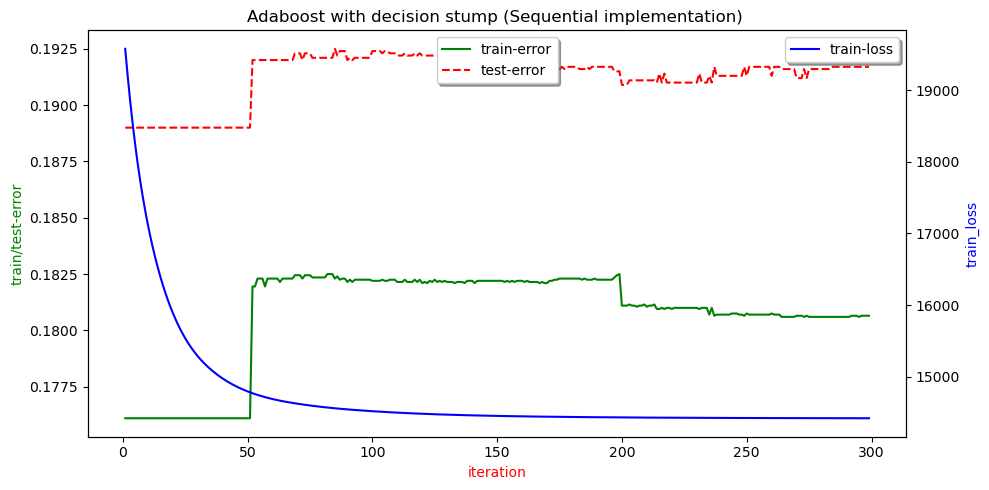

In [12]:
adaboost_object.do_plot(train_error,train_loss,test_error,test_loss)